1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

The global minimum of the function (found using the function basinhopping) is:	 -1.0316284534898772 
Which can be found at:	( 0.0898420093013501 , -0.7126564010228108 )
Minimum found with local minima by optimize.minimize:  -1.0316284534898768
Number of minima:	 2
Global minima:	 [-1.0316284534898768, -1.0316284534898768]
Points related to each global minima:	 [array([-0.08984202,  0.7126564 ]), array([ 0.08984201, -0.71265641])]
The function has 2 global minima, which can be found in the points ( -0.08984201975387214 , 0.712656396030507 ) and ( 0.08984200715562794 , -0.7126564101375317 ). In these points the value of the function is:  -1.0316284534898768
The new minimum found is: 0.0 . This is because the function has a local minimum in (0,0) which is the one found by running optimize.minimize on the function with such an initial guess.


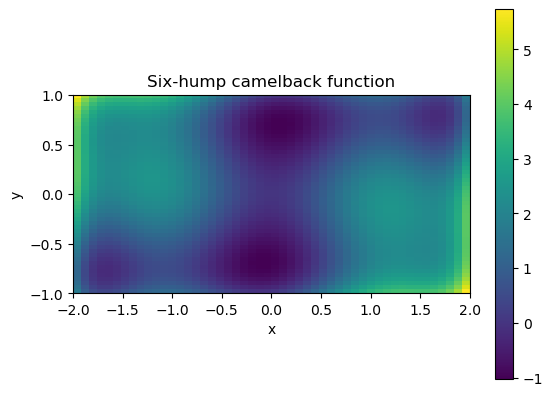

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from scipy import optimize
def f(z):
    x = z[0]
    y = z[1]
    return (4 - 2.1*x**2 + (x**4)/3)*(x**2) + x*y + (4*(y**2) -4)*(y**2)

x0 = [0,0]
x = np.linspace(-2,2)
y = np.linspace(-1,1)
initial_guess = [(i,j) for i in range(-2,3) for j in range(-1,2)]
bh_solution = optimize.basinhopping(f, x0)
print("The global minimum of the function (found using the function basinhopping) is:\t", bh_solution['lowest_optimization_result']['fun'], 
      "\nWhich can be found at:\t(", bh_solution['x'][0], ",", bh_solution['x'][1], ")")
minima = []
points_min = []
solution_all = [optimize.minimize(f, x00) for x00 in initial_guess]
all_min = [solution['fun']for solution in solution_all]
glob_min = np.min(all_min)
print("Minimum found with local minima by optimize.minimize: ", glob_min)
for sol in solution_all:
    if sol['fun']<=glob_min:
        minima.append(sol['fun'])
        points_min.append(sol['x'])
print("Number of minima:\t", len(minima))
print("Global minima:\t", minima)
print("Points related to each global minima:\t", points_min)
print("The function has", len(minima), "global minima, which can be found in the points (", points_min[0][0], ",", points_min[0][1], ") and (", 
      points_min[1][0], ",", points_min[1][1], "). In these points the value of the function is: ", minima[0])
# Now let's see what happens if we make just the assumpion that the initial guess is (0,0)
new_sol = optimize.minimize(f, (0,0))
new_min = new_sol['fun']
print("The new minimum found is:", new_min, ". This is because the function has a local minimum in (0,0) which is the one found by running \
optimize.minimize on the function with such an initial guess.")
X,Y = np.meshgrid(x, y)
Z = f([X, Y])
plb.imshow(Z, extent=(x.min(), x.max(), y.min(), y.max()))
plb.title("Six-hump camelback function")
plb.colorbar()
plb.xlabel("x")
plb.ylabel("y")
plb.show()

2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

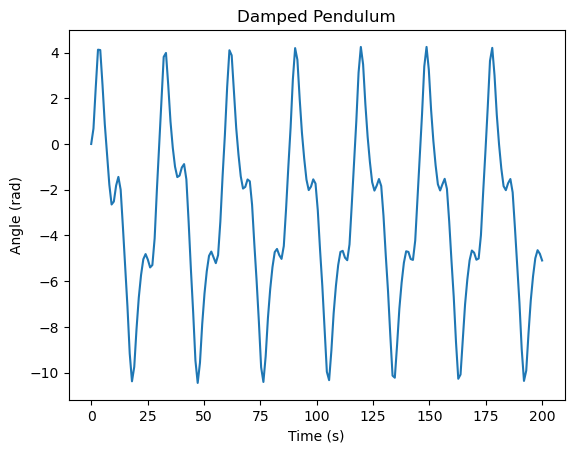

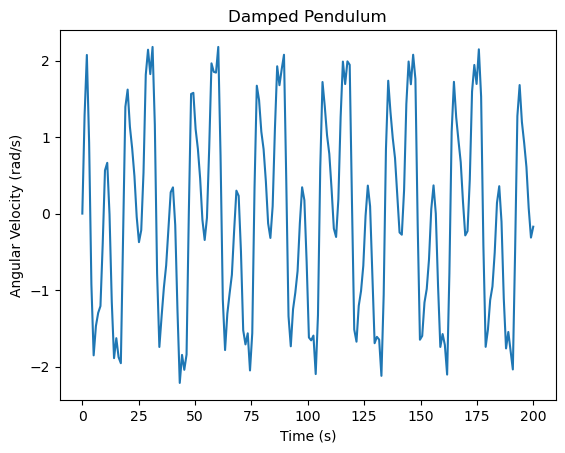

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def deriv(X, t, g, l, d):
    theta = X[0]
    omega = X[1] 
    dtheta_dt = omega
    # Here I didn't know how to interpret the symbol in the expression of domega_dt, dependeing on the value inside of the cosine function we obtain
    # different results.
    # domega_dt = -1/Q * omega + g/l * np.sin(theta) + d * np.cos(omega * t / (2*np.pi))
    # domega_dt = -1/Q * omega + g/l * np.sin(theta) + d * np.cos(omega * t)
    domega_dt = -1/Q * omega + g/l * np.sin(theta) + d * np.cos(0.65 * t)

    return (dtheta_dt, domega_dt)

# Set the parameters
g = 9.81 
l = 10  
d = 1.5  
omega = 0.65
Q = 2.0
theta0 = 0.0
omega0 = 0.0
t = np.linspace(0, 200, 200)  # Taking 200 time steps of 1 s
X = odeint(deriv, (theta0, omega0), t, args=(g, l, d))
# The vertical lines were introduced (and then removed) to see how the pendulum behaved in the maximum value for the angle.
plt.plot(t, X[:, 0])
# plt.axvline(X[50,0])
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Damped Pendulum')
plt.show()
plt.plot(t, X[:, 1])
# plt.axvline(X[50,0])
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Damped Pendulum')
plt.show()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

Lynx population period: 10.5
Hare population period: 10.5


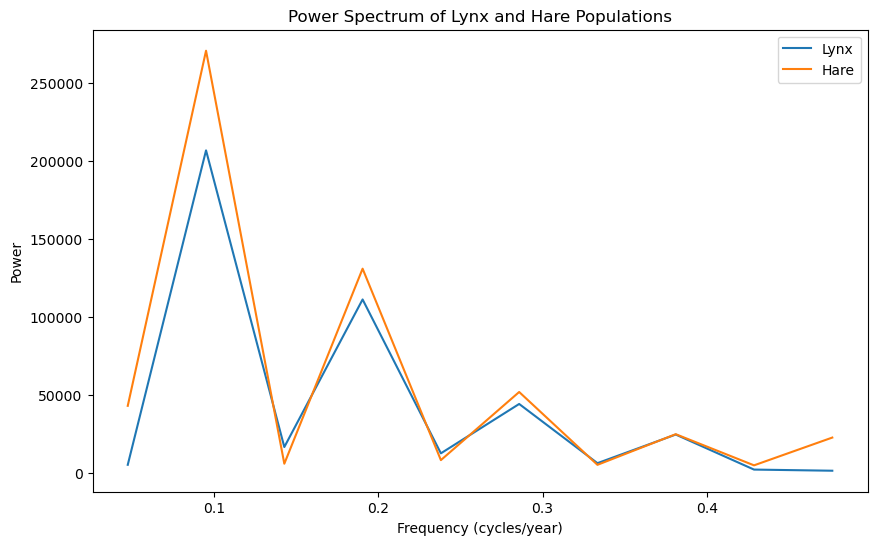

In [3]:
# !wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
import pandas as pd
 
 # Load the data
filename = "./data/populations.txt"
data = pd.read_csv(filename, sep='\t')
lynx_population = data['lynx']
hare_population = data['hare']
lynx_fft = fft(lynx_population.values)
hare_fft = fft(hare_population.values)
lynx_power = np.abs(lynx_fft)
hare_power = np.abs(hare_fft)
lynx_dominant_frequencies = fftfreq(len(lynx_population), d=1)
hare_dominant_frequencies = fftfreq(len(hare_population), d=1)
pos_lynx_dominant_frequencies = np.where(lynx_dominant_frequencies>0)
pos_hare_dominant_frequencies = np.where(hare_dominant_frequencies>0)
lynx_dominant_frequencies = lynx_dominant_frequencies[pos_lynx_dominant_frequencies]
hare_dominant_frequencies = hare_dominant_frequencies[pos_hare_dominant_frequencies]
lynx_power = lynx_power[pos_lynx_dominant_frequencies]
hare_power = hare_power[pos_hare_dominant_frequencies]
lynx_period = 1 / lynx_dominant_frequencies[(lynx_power).argmax()]
hare_period = 1 / hare_dominant_frequencies[(hare_power).argmax()]
print('Lynx population period:', lynx_period)
print('Hare population period:', hare_period)
plt.figure(figsize=(10, 6))
plt.plot(lynx_dominant_frequencies, lynx_power)
plt.plot(hare_dominant_frequencies, hare_power)
plt.title('Power Spectrum of Lynx and Hare Populations')
plt.xlabel('Frequency (cycles/year)')
plt.ylabel('Power')
plt.legend(['Lynx', 'Hare'])
plt.show()

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

Text(0.5, 1.0, 'Reconstructed Image in black and white')

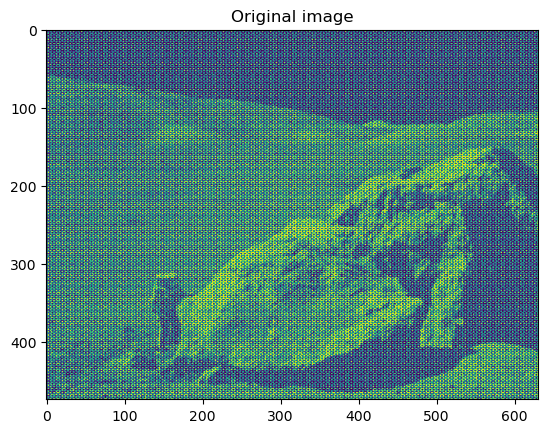

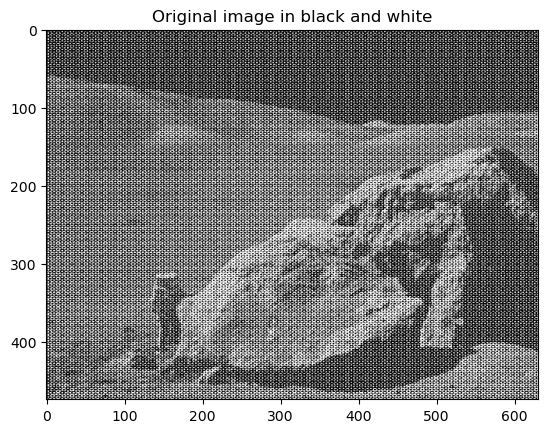

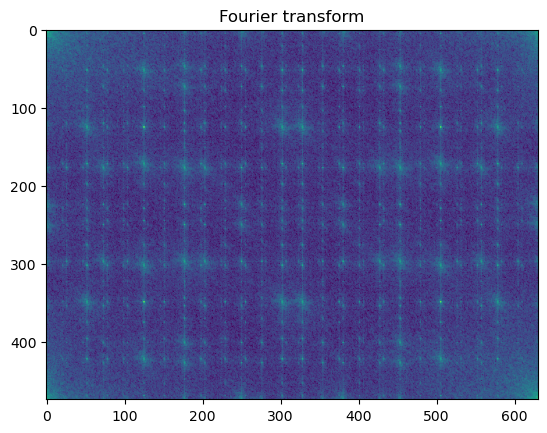

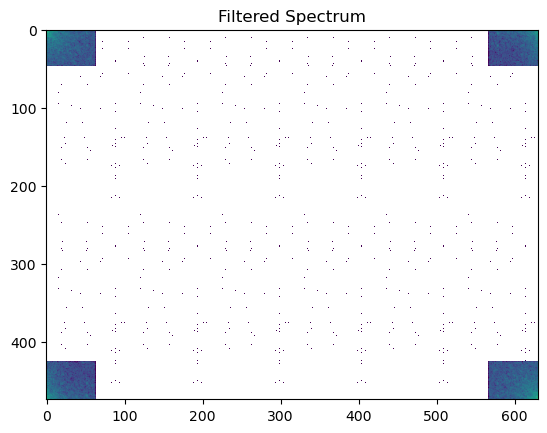

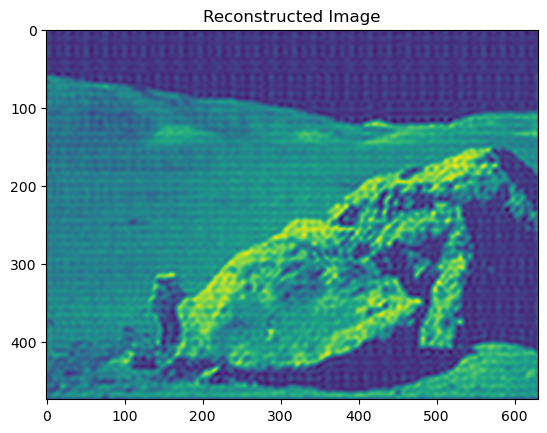

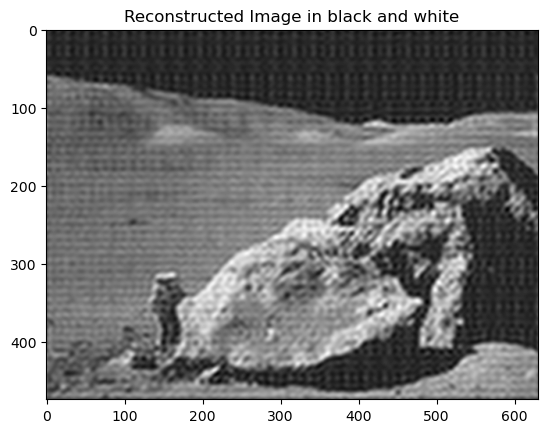

In [4]:
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import fftpack

def spectrum_plot(im_fft):
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
original_image = plt.imread("./images/moonlanding.png")
plt.figure()
plt.imshow(original_image)
plt.title('Original image')
plt.figure()
plt.imshow(original_image, cmap='gray')
plt.title('Original image in black and white')
image_fft = fftpack.fft2(original_image) #FFT of the image
plt.figure()
spectrum_plot(image_fft) #Plot of the FFT
plt.title('Fourier transform')
keep_fraction = 0.1
img_fft_copy = image_fft.copy()
r, c = img_fft_copy.shape
img_fft_copy[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
img_fft_copy[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
plt.figure()
spectrum_plot(img_fft_copy)
plt.title('Filtered Spectrum')
im_new = fftpack.ifft2(img_fft_copy).real
plt.figure()
plt.imshow(im_new)
plt.title('Reconstructed Image')
plt.figure()
plt.imshow(im_new, cmap='gray')
plt.title('Reconstructed Image in black and white')